In [1]:
!which python

/Users/aaron/Documents/github/ssd-pytorch/venv/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox import utils
from ssdmultibox.bboxer import Bboxer, TensorBboxer
from ssdmultibox.config import cfg
from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox.plotting import *
from ssdmultibox.predict import Predict
from ssdmultibox.utils import open_image

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cpu')

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
LR = 1e-2

criterion = SSDLoss(alpha=.2)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
current_time = time.time()

In [27]:
from ssdmultibox.datasets import TransformsTrainPascalFlatDataset
from albumentations import Compose, HorizontalFlip

BATCH = 4

TransformsTrainPascalFlatDataset.__len__ = lambda self: BATCH

# train_dataset = TrainPascalFlatDataset()
train_dataset = TransformsTrainPascalFlatDataset(
    transform=Compose([HorizontalFlip(p=0)],
                       bbox_params={'format': 'coco', 'label_fields': ['category_id']}))

len(train_dataset) 

4

In [28]:
train_dataset

In [29]:
NUM_WORKERS = 0
SHUFFLE = False
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TransformsTrainPascalFlatDataset at 0x143077710>,
 'batch_size': 4,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x1520352b0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x152035fd0>,
 '_DataLoader__initialized': True}

In [30]:
EPOCHS = 1

for epoch in range(EPOCHS):
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 512.6642 neg_hard_mining_loss: 1472.2266
n: 37.0 bbs_loss: 541.3249 cats_loss: 1984.8907
epoch: 0 step: 0 loss: 68.2761 time: 103.5190



In [31]:
bbs_preds, cats_preds = preds

In [32]:
idx = 1
cls_id = 6
dataset = train_dataset

In [33]:
gt_bbs[idx][0]

tensor([ 50.2747, 115.0000, 163.0110, 173.3750])

In [34]:
ims[0].shape

torch.Size([3, 300, 300])

In [35]:
gt_cats.shape

torch.Size([4, 11640])

In [36]:
gt_cats[idx]

tensor([20, 20, 20,  ..., 20, 20, 20])

In [37]:
# [ 50.27472527 125.625      163.01098901 184.        ]

In [38]:
# targets
get_anchor_bbs_targets(idx, gt_cats)

(tensor([[ 30., 120., 150., 180.],
         [  0., 120., 180., 180.],
         [100.,  50., 200., 250.]]), tensor([14, 14, 12]))

In [39]:
get_pred_targets(idx, gt_cats, preds)[0]

tensor([[ 30.0751, 119.9471, 150.0040, 179.8070],
        [  0.1331, 120.2284, 179.7250, 180.1483],
        [100.2408,  49.9581, 200.1749, 250.0940]], grad_fn=<TakeBackward>)

In [40]:
preds[0].shape

torch.Size([4, 11640, 4])

In [41]:
mask = gt_cats[idx] != 20
bbs_preds[idx][mask].type(torch.int)

tensor([[ 30, 119, 150, 179],
        [  0, 120, 179, 180],
        [100,  49, 200, 250]], dtype=torch.int32)

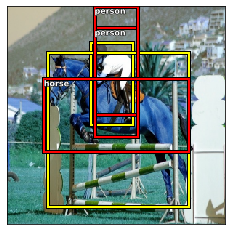

In [44]:
model_output = image_ids, ims, gt_bbs, gt_cats
idx = 1
transform_plot_anchor_bbs(model_output, idx, dataset)

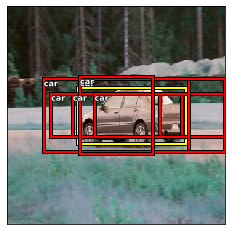

In [40]:
def transform_plot_single_predictions(chw_im, gt_bbs, gt_cats, idx, dataset, targets, ax=None):
    im = np.transpose(chw_im, (1,2,0))
    ax = show_img(im, ax=ax)

    mask = gt_cats[idx] != 20
    # anchors
    for bb in gt_bbs[idx][mask]:
        pascal_bb = Bboxer.fastai_bb_to_pascal_bb(bb)
        draw_rect(ax, pascal_bb, edgecolor='yellow')
    
    for bb, cat in zip(*targets):
        pascal_bb = Bboxer.fastai_bb_to_pascal_bb(bb)
        draw_rect(ax, pascal_bb, edgecolor='red')
        draw_text(ax, pascal_bb[:2], cat_names[cat.item()], sz=8)
        
idx = 3
cat_names = dataset.categories()
chw_im = ims[idx]
transform_plot_single_predictions(
    chw_im, gt_bbs, gt_cats, idx, cat_names, targets=get_targets(gt_cats, idx)
)

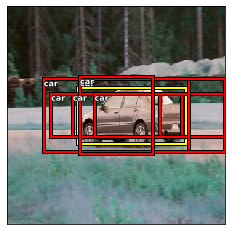

In [46]:
def transform_plot_anchor_bbs(model_output, idx, dataset):
    cat_names = dataset.categories()
    image_ids, ims, gt_bbs, gt_cats = model_output
    chw_im = ims[idx]
    transform_plot_single_predictions(
        chw_im, gt_bbs, gt_cats, idx, cat_names, targets=get_targets(gt_cats, idx)
    )
    
model_output = image_ids, ims, gt_bbs, gt_cats
idx = 3
transform_plot_anchor_bbs(model_output, idx, dataset)

single

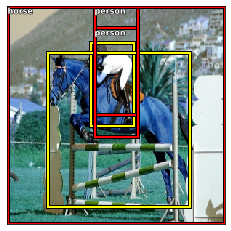

In [15]:
plot_anchor_bbs(dataset, image_ids, idx, gt_cats)

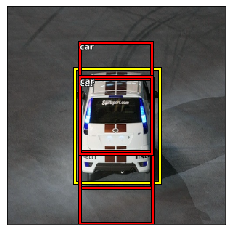

In [27]:
plot_preds(dataset, image_ids, idx, bbs_preds, gt_cats)

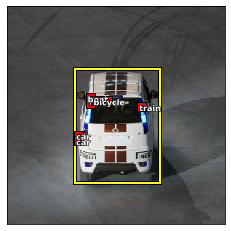

In [28]:
plot_nms_preds(dataset, image_ids, idx, preds, limit=5)

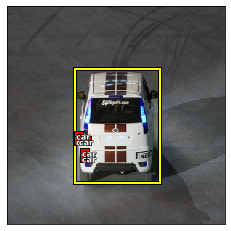

In [29]:
plot_nms_single_preds(dataset, image_ids, idx, cls_id, preds, limit=5)

multiple

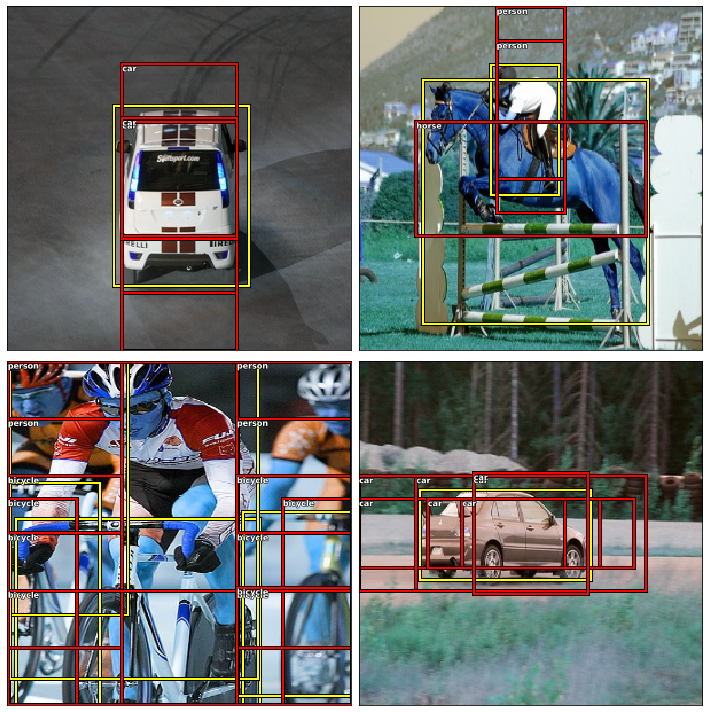

In [46]:
plot_multiple(plot_anchor_bbs, dataset=dataset, image_ids=image_ids, gt_cats=gt_cats)

In [20]:
# plot_multiple(plot_preds, dataset=dataset, image_ids=image_ids, gt_cats=gt_cats, bbs_preds=bbs_preds)

In [21]:
# plot_multiple(plot_nms_preds, dataset=dataset, image_ids=image_ids, preds=preds)

In [22]:
# plot_multiple(plot_nms_single_preds, dataset=dataset, image_ids=image_ids, cls_id=cls_id, preds=preds)

# albumentations

In [23]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [24]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [25]:
image_id = image_ids[idx].item()
ann = dataset.get_annotations()[image_id]
ann, idx

({'image_path': '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000012.jpg',
  'bbs': [[155, 96, 196, 174]],
  'cats': [6]},
 0)

In [26]:
category_id_to_name = dataset.categories()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


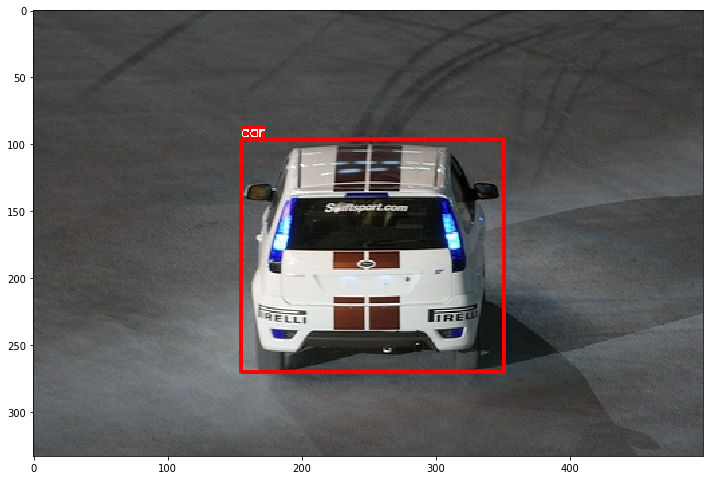

In [37]:
annotations = {
    'image': utils.open_image(ann['image_path']),
    'bboxes': ann['bbs'],
    'category_id': ann['cats']
}
visualize(annotations, category_id_to_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


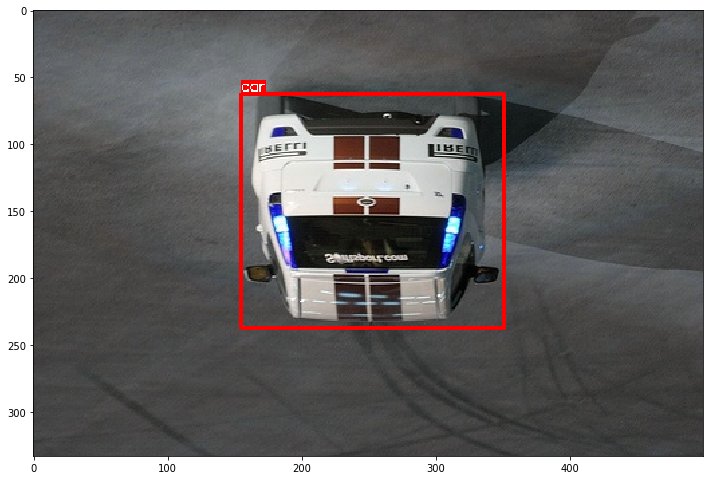

In [35]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'coco', 'label_fields': ['category_id']})

aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


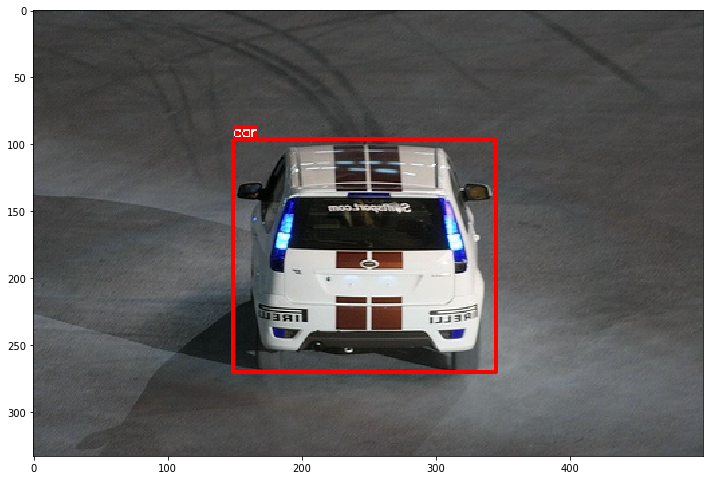

In [33]:
def visualize_aug(augs, annotations, idx=None):
    aug = get_aug(augs)
    augmented = aug(**annotations)
    visualize(augmented, category_id_to_name)
    
visualize_aug([HorizontalFlip(p=1)], annotations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


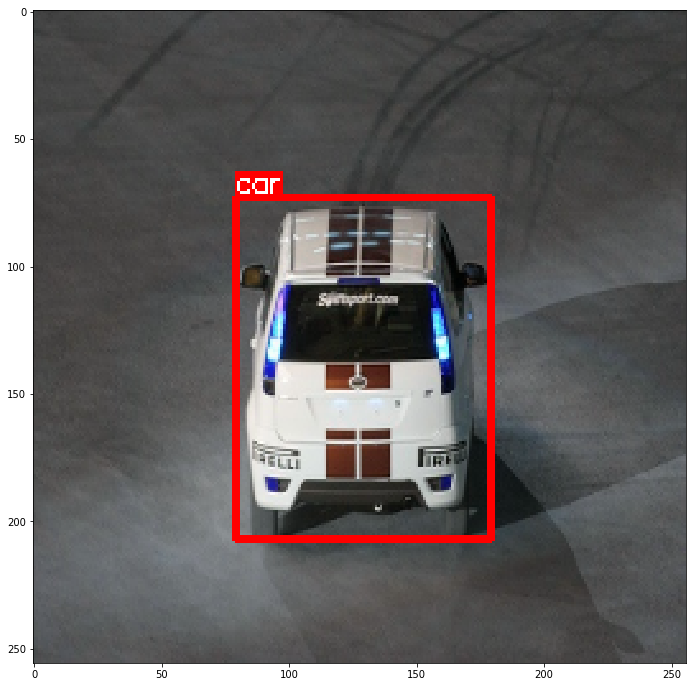

In [30]:
visualize_aug([Resize(p=1, height=256, width=256)], annotations)

In [53]:
idx = 1
image_id = image_ids[idx].item()
ann = dataset.get_annotations()[image_id]

annotations = {
    'image': utils.open_image(ann['image_path']),
    'bboxes': ann['bbs'],
    'category_id': ann['cats']
}

def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'coco', 'label_fields': ['category_id']})

def visualize_aug(augs, annotations, idx=None):
    aug = get_aug(augs)
    augmented = aug(**annotations)
    visualize(augmented, category_id_to_name)
    
# visualize_aug([HorizontalFlip(p=1)], annotations)

Compose([HorizontalFlip(p=1)], bbox_params={'format': 'coco', 'label_fields': ['category_id']})

In [42]:
im = utils.open_image(ann['image_path'])
im.shape

(364, 480, 3)

In [17]:
# import pdb
# import json

# import cv2
# import numpy as np
# import torch
# from torch.utils.data import Dataset

# from ssdmultibox.bboxer import Bboxer
# from ssdmultibox.config import cfg
# from ssdmultibox.utils import open_image

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# SIZE = 300

# NUM_CLASSES = 21

# BATCH = 4

# # IoU threshold
# THRESH = 0.5

# FEATURE_MAPS = [38, 19, 10, 5, 3, 1]

# IMAGES = 'images'
# ANNOTATIONS = 'annotations'
# CATEGORIES = 'categories'
# ID = 'id'
# NAME = 'name'
# IMAGE_ID = 'image_id'
# BBOX = 'bbox'
# BBS = 'bbs'
# CATS = 'cats'
# CATEGORY_ID = 'category_id'
# FILE_NAME = 'file_name'
# IMAGE = 'image'
# CATEGORY = 'category'
# TRAIN = 'train'
# VAL = 'val'
# TEST = 'test'
# IMAGE = 'image'
# IMAGE_PATH = 'image_path'

# class TransformsTrainPascalFlatDataset(TrainPascalFlatDataset):
#     def __init__(self, transform=None):
#         super().__init__()
#         self.transform = transform
        
#     def __getitem__(self, idx):
#         """
#         Returns:
#             image_id (int)
#             chw_im (3d array): CHW of image
#             gt_bbs (2d array): (n bbs, 4)
#             gt_cats (1d array): (n cats,)
#         """
#         image_ids = self.get_image_ids()
#         image_id = image_ids[idx]
#         ann = self.get_annotations()[image_id]
#         bbs = np.array(ann[BBS])
#         cats = np.array(ann[CATS])
#         image_paths = self.images()
#         im = open_image(image_paths[image_id])
        
#         if self.transform:
#             im, bbs, cats = self.transform_data(im, bbs, cats)

#         chw_im = self.scaled_im_by_size_and_chw_format(im)
#         gt_bbs, gt_cats = Bboxer.get_stacked_gt(bbs, cats, im)
#         gt_bbs *= cfg.NORMALIZED_SIZE
            
#         return image_id, chw_im, gt_bbs, gt_cats
    
#     def transform_data(self, im, bbs, cats):
#         annotations = {
#             'image': im,
#             'bboxes': bbs,
#             'category_id': cats
#         }
#         ret = self.transform(**annotations)
#         return ret['image'], np.array(ret['bboxes']), np.array(ret['category_id'])

transforms_dataset = TransformsTrainPascalFlatDataset(
    transform=Compose([HorizontalFlip(p=1)],
                       bbox_params={'format': 'coco', 'label_fields': ['category_id']}))

idx = 1
image_id, chw_im, gt_bbs, gt_cats = transforms_dataset[idx]

image_id, chw_im.shape, gt_bbs.shape, gt_cats.shape

(17, (3, 300, 300), (11640, 4), (11640,))

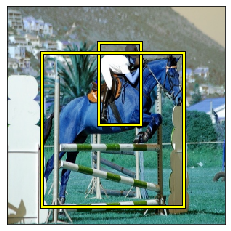

In [19]:
hwc_im = np.transpose(chw_im, (1,2,0))
mask = gt_cats != 20

ax = show_img(hwc_im)

for bb in gt_bbs[mask]:
    pascal_bb = Bboxer.fastai_bb_to_pascal_bb(bb)
    draw_rect(ax, pascal_bb, edgecolor='yellow')

In [20]:
print(gt_bbs[0])

[ 50.27472527 125.625      163.01098901 184.        ]


In [113]:
mask = gt_cats != 20
gt_bbs[mask]

array([[ 50.27472527, 125.625     , 163.01098901, 184.        ],
       [ 50.27472527, 125.625     , 163.01098901, 184.        ],
       [ 63.46153846,  48.125     , 275.92307692, 243.375     ]])

In [77]:
idx

0

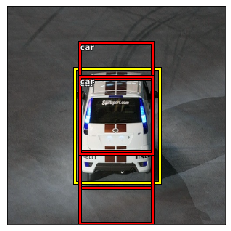

In [81]:
plot_anchor_bbs(transforms_dataset, image_ids, idx, gt_cats)

In [79]:
%debug

> /Users/aaron/Documents/github/ssd-pytorch/ssdmultibox/plotting.py(70)get_targets()
     68     using the anchor box offsets
     69     """
---> 70     gt_cat = torch.tensor(gt_cats[idx])
     71     not_bg_mask = gt_cat != 20
     72     not_bg_mask = (not_bg_mask == 1).nonzero()

ipdb> gt_cats.shape
(11640,)
ipdb> type(gt_cats)
<class 'numpy.ndarray'>
ipdb> idx
0
ipdb> gt_cat = torch.tensor(gt_cats[idx], dtype=torch.int)
ipdb> gt_cat
tensor(20, dtype=torch.int32)
ipdb> gt_cats[idx]
20
ipdb> idx
0
ipdb> gt_cats.shape
(11640,)
ipdb> c
